# Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.preprocessing import OneHotEncoder

Mounted at /content/drive


# Cargar datos

In [ ]:
path='/content/drive/Shareddrives/Data_TFM/Dataset_Final/df_final_v5.csv'

df= pd.read_csv(path, sep="	",  low_memory=False)

# Modelar el Random Forest

## Crear y entrenar el modelo

In [ ]:
# Ordenar el dataset según date_day y crear la variable month
df_sorted = df.sort_values(by=["date_day", "unique_venue_id"])
df_sorted["month"] = pd.to_datetime(df_sorted["date_day"]).dt.month

# Crear los conjuntos de train y test
X_train = df_sorted[df_sorted["date_day"] <= "2022-12-31"].drop(["churn"], axis=1)
X_test = df_sorted[(df_sorted["date_day"] > "2022-12-31") & (df_sorted["date_day"] < "2023-06-01")].drop(["churn"], axis=1)
y_train = df_sorted[df_sorted["date_day"] <= "2022-12-31"][["unique_venue_id", "date_day","churn"]]
y_test = df_sorted[(df_sorted["date_day"] > "2022-12-31") & (df_sorted["date_day"] < "2023-06-01")][["unique_venue_id", "date_day","churn"]]

# Crear los index
X_train = X_train.set_index(['date_day', 'unique_venue_id'])
X_test = X_test.set_index(['date_day', 'unique_venue_id'])
y_train = y_train.set_index(['date_day', 'unique_venue_id'])
y_test = y_test.set_index(['date_day', 'unique_venue_id'])

- Hemos creado la variable "month" para añadirla al modelo ya que en el EDA hemos visto que existe estacionalidad.
- Hemos creado los conjuntos train y test utilizando "date_day" para segmentar las conjuntos en función de la fecha debido a la estacionalidad.
    - Train: El conjunto train contiene todos los datos del 2021 y el 2022.
    - Test: El conjunto test contiene todos los datos de Enero del 2023 a Mayo del 2023.
    - Validation: El conjunto de validación será a partir de Junio del 2023.
- Hemos creado los indices "date_day" y "unique_venue_id" para mantener los conjuntos ordenados.

In [ ]:
# Crear la instancia del Random Forest
random_forest_clf = RandomForestClassifier()

# Entrenar el modelo
model_churn_random_forest = random_forest_clf.fit(X_train, y_train)

# Obtener las probabilidades de las clases y mantener los índices
probs_train = pd.DataFrame(model_churn_random_forest.predict_proba(X_train), index=X_train.index)
probs_test = pd.DataFrame(model_churn_random_forest.predict_proba(X_test), index=X_test.index)


# Obtener las predicciones y mantener los índices
preds_train = pd.DataFrame(model_churn_random_forest.predict(X_train), index=X_train.index)
preds_test = pd.DataFrame(model_churn_random_forest.predict(X_test), index=X_test.index)

# Obtener las predicciones para crear la matriz de confusión y el classification report
prediction_churn_random_forest=model_churn_random_forest.predict(X_test)

<ipython-input-4-f9231f8606b7>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_churn_random_forest = random_forest_clf.fit(X_train, y_train)


- Hemos creado 2 dataframes distintos tanto para el conjunto de train como de test:
    - probs: Contiene las probabilidades de que el registro sea churn (0-1).
    - preds: Contiene la predicción de que el registro sea churn.

## Evaluar el modelo (métrica propia)

Vamos a crear una métrica propia llamada "Accuracy_top_prob" que va a medir el porcentaje de aciertos que hemos obtenido en los registros con una probabilidad de hacer churn del 80%. Aplicaremos esta métrica al conjunto de train y test.

Se aplicará en train y test para analizar el comportamiento en ambas ventanas temporales

In [ ]:
# Unificar los DataFrames
df_train = pd.concat([probs_train, preds_train, y_train], axis=1)
df_train = df_train.set_axis(["prob_0", "prob_1", "pred", "churn"], axis=1)

print("La cantidad de rows con una probabilidad de churn del 100% es:", len(df_train[df_train["prob_1"] == 1]))
print("El porcentaje de rows con una probabilidad de churn del 100% es:", len(df_train[df_train["prob_1"] == 1])/len(df_train))
print("La cantidad de rows con una probabilidad de churn del 0% es:",len(df_train[df_train["prob_1"] == 0]))
print("El porcentaje de rows con una probabilidad de churn del 0% es:",len(df_train[df_train["prob_1"] == 0])/len(df_train))

df_train

La cantidad de rows con una probabilidad de churn del 100% es: 451662
El porcentaje de rows con una probabilidad de churn del 100% es: 0.17942155218062997
La cantidad de rows con una probabilidad de churn del 0% es: 655728
El porcentaje de rows con una probabilidad de churn del 0% es: 0.26048623875442284


prob_0    prob_1  pred  churn
date_day   unique_venue_id                                 
2021-06-01 11000000002      0.000000  1.000000   1.0    1.0
           11000000004      0.960449  0.039551   0.0    0.0
           11000000006      1.000000  0.000000   0.0    0.0
           11000000007      0.920728  0.079272   0.0    0.0
           11000000008      0.920728  0.079272   0.0    0.0
...                              ...       ...   ...    ...
2022-12-01 13026415610      0.000000  1.000000   1.0    1.0
           13026415939      0.000000  1.000000   1.0    1.0
           13026416171      1.000000  0.000000   0.0    0.0
           13026416368      1.000000  0.000000   0.0    0.0
           13026416403      0.000000  1.000000   1.0    1.0

[2517323 rows x 4 columns]

- El porcentaje de registros del conjunto train con una probabilidad del 100% de hacer churn es del 18%
- El porcentaje de registros del conjunto train con una probabilidad del 100% de no hacer churn es del 26%

In [ ]:
# Unificar los DataFrames
df_test = pd.concat([probs_test, preds_test, y_test], axis=1)
df_test = df_test.set_axis(["prob_0", "prob_1", "pred", "churn"], axis=1)

print("La cantidad de rows con una probabilidad de churn del 100% es:", len(df_test[df_test["prob_1"] == 1]))
print("El porcentaje de rows con una probabilidad de churn del 100% es:", len(df_test[df_test["prob_1"] == 1])/len(df_test))
print("La cantidad de rows con una probabilidad de churn del 0% es:",len(df_test[df_test["prob_1"] == 0]))
print("El porcentaje de rows con una probabilidad de churn del 0% es:",len(df_test[df_test["prob_1"] == 0])/len(df_test))

df_test

La cantidad de rows con una probabilidad de churn del 100% es: 116455
El porcentaje de rows con una probabilidad de churn del 100% es: 0.1393775971352521
La cantidad de rows con una probabilidad de churn del 0% es: 262676
El porcentaje de rows con una probabilidad de churn del 0% es: 0.31438023017559985


prob_0    prob_1  pred  churn
date_day   unique_venue_id                                 
2023-01-01 11000000002      0.000000  1.000000   1.0    1.0
           11000000003      0.110947  0.889053   1.0    1.0
           11000000004      1.000000  0.000000   0.0    0.0
           11000000005      0.020000  0.980000   1.0    1.0
           11000000006      0.797024  0.202976   0.0    0.0
...                              ...       ...   ...    ...
2023-05-01 12000048321      1.000000  0.000000   0.0    0.0
           12000048322      1.000000  0.000000   0.0    0.0
           12000048323      1.000000  0.000000   0.0    0.0
           12000048324      1.000000  0.000000   0.0    0.0
           12000048325      1.000000  0.000000   0.0    0.0

[835536 rows x 4 columns]

- El porcentaje de registros del conjunto train con una probabilidad del 100% de hacer churn es del 14%
- El porcentaje de registros del conjunto train con una probabilidad del 100% de no hacer churn es del 31%

In [ ]:
df_top_predictions_train = df_train.sort_values(by=["prob_1"], ascending=False).head(100)
df_top_predictions_train["correct"] = (df_top_predictions_train["pred"] == df_top_predictions_train["churn"]).astype(float)
accuracy_top_prob_train = df_top_predictions_train["correct"].sum()/100
accuracy_top_prob_train

1.0

In [ ]:
df_top_predictions_test = df_test.sort_values(by=["prob_1"], ascending=False).head(100)
df_top_predictions_test["correct"] = (df_top_predictions_test["pred"] == df_top_predictions_test["churn"]).astype(float)
accuracy_top_prob_test = df_top_predictions_test["correct"].sum()/100
accuracy_top_prob_test

0.99

Como se puede observar, el conjunto de entrenamiento ha mostrado un rendimiento superior al conjunto de prueba. Esto es esperado, ya que el modelo ha sido entrenado con los datos del conjunto de entrenamiento y es más familiarizado con ellos.

## Evaluar el modelo (matriz de confusión)

[Text(0, 0, 'Not Churn'), Text(0, 1, 'Churn')]

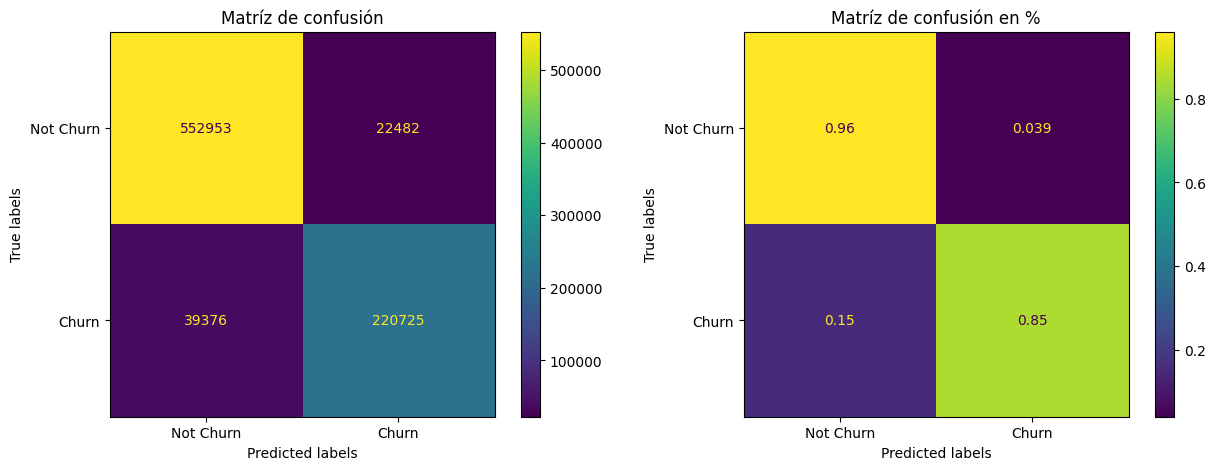

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Matriz de confusión
cm = confusion_matrix(y_test, prediction_churn_random_forest)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax1)
ax1.set_title("Matríz de confusión")
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_xticklabels(['Not Churn', 'Churn'])
ax1.set_yticklabels(['Not Churn', 'Churn'])

# Matriz de confusión en porcentaje
cm_percent = cm / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion_matrix=cm_percent).plot(ax=ax2)
ax2.set_title("Matríz de confusión en %")
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_xticklabels(['Not Churn', 'Churn'])
ax2.set_yticklabels(['Not Churn', 'Churn'])

In [ ]:
print(classification_report(y_test, prediction_churn_random_forest))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95    575435
         1.0       0.91      0.85      0.88    260101

    accuracy                           0.93    835536
   macro avg       0.92      0.90      0.91    835536
weighted avg       0.93      0.93      0.93    835536



La precisión es alta para ambas clases. Esto indica que el modelo tiene una buena capacidad para predecir correctamente los casos positivos y negativos en ambas clases. No obstante, el recall es ligeramente más bajo para la clase "1", lo que indica que el modelo puede tener más dificultades para identificar correctamente los casos de churn.

En resumen, aunque el modelo muestra buenos resultados en términos de precisión y recall para ambas clases, es importante considerar que el recall para la clase minoritaria puede ser de mayor relevancia en un problema desbalanceado de churn.

Por último, mencionar que vamos a intentar buscar los mejores hiperparámetros en base a la mejora del recall.

**REVISAR Y AÑADIR CONCLUSIONES CAMI Y BRUNO**

## Importancia de las variables

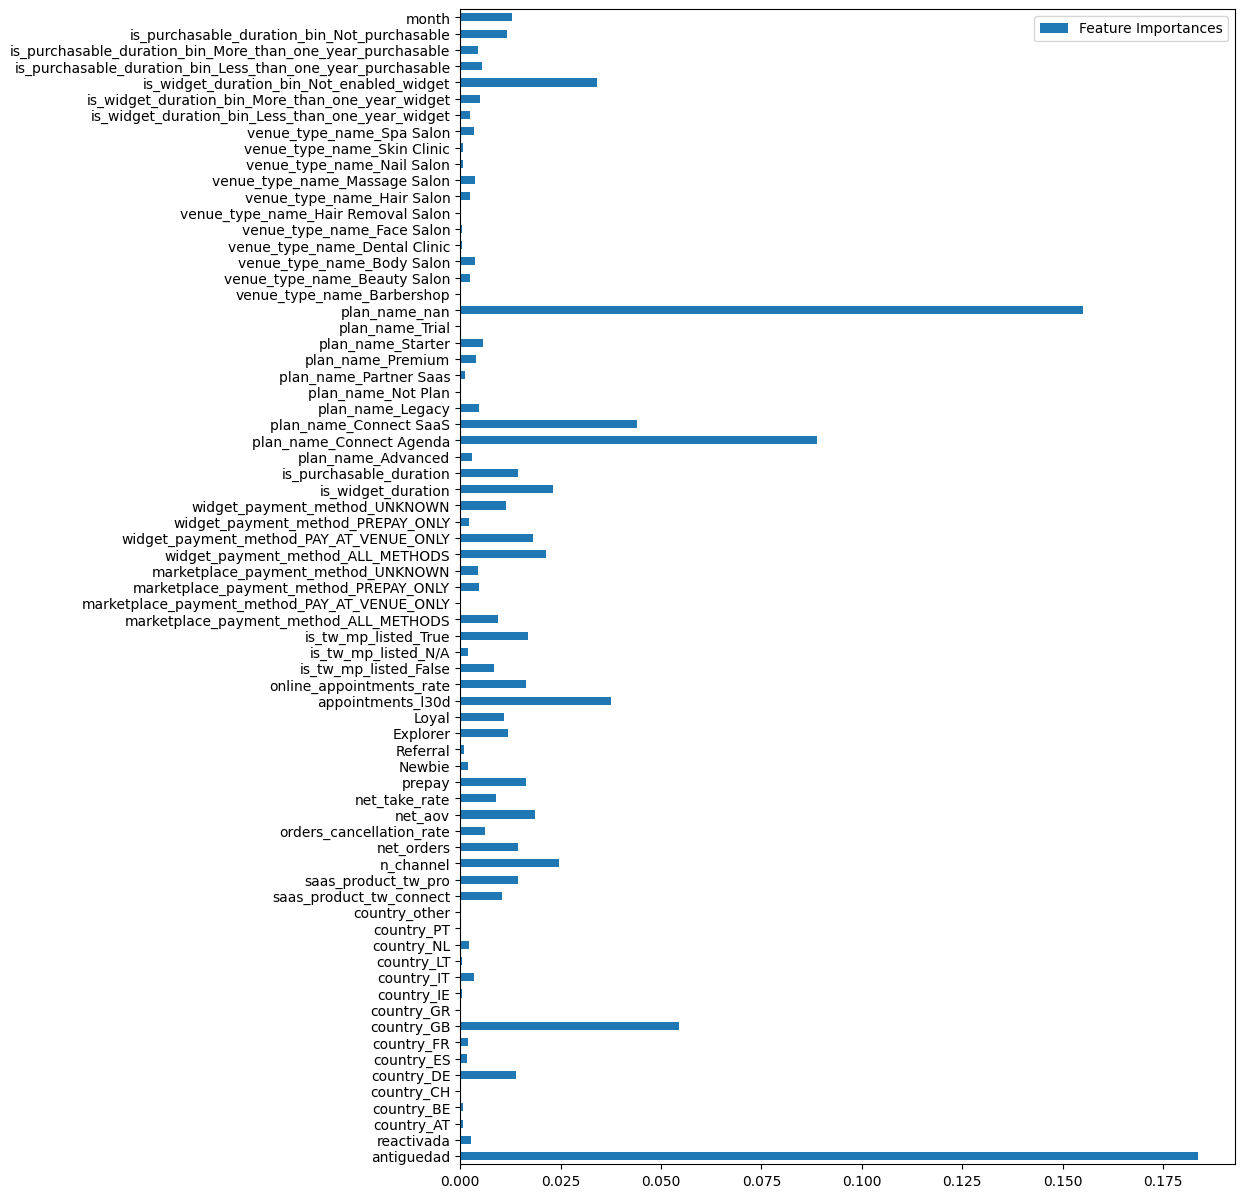

In [ ]:
df_imp = pd.DataFrame(model_churn_random_forest.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Feature Importances"])
df_imp.T.plot.barh(figsize=(10, 15))
plt.legend()

<Figure size 1000x800 with 0 Axes>

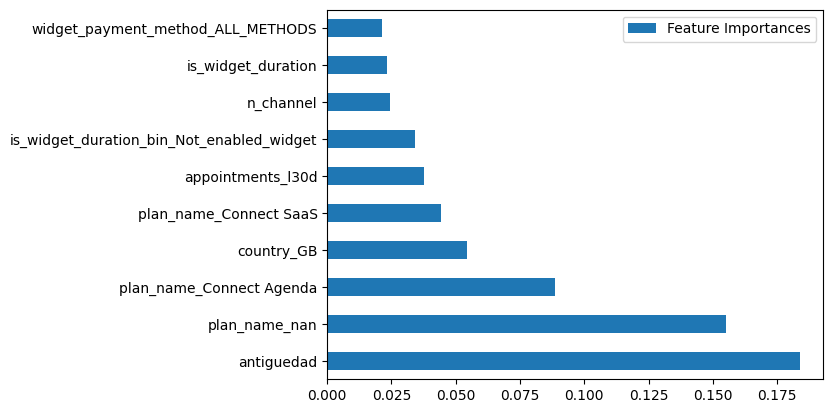

In [ ]:
# Transponer el DataFrame y seleccionar las 10 características más importantes
top_10_imp = df_imp.T.nlargest(10, "Feature Importances")

# Graficar las 10 características más importantes
plt.figure(figsize=(10, 8))
top_10_imp.plot.barh()
plt.legend()

# Mostrar el gráfico
plt.show()

Las variables con mayor importancia para este modelo son:
- Antiguedad
- Plan_name_nan
- Plan_name_connect_agenda
- Country_GB
- Plan_name_connect_saas
- Appointments_l30d



## Buscar mejores hiperparámetros

In [ ]:
# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [3, 6, 9],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}


# Realizar la búsqueda en cuadrícula
scorer = make_scorer(recall_score)
grid_search = GridSearchCV(estimator=model_churn_random_forest, param_grid=param_grid, cv=3, scoring=scorer)
grid_search.fit(X_train, y_train)


# Obtener los mejores valores encontrados
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Imprimir los resultados
print("Mejores parámetros encontrados:", best_params)
print("Mejor modelo encontrado:", best_model)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Mejores parámetros encontrados: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 3}
Mejor modelo encontrado: RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=10,
                       n_estimators=3)



## Mejor modelo encontrado: RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=6)

Luego de haber obtenido los mejores parametros para el modelo de benchmarking, se procederá con el modelo optimizado en el siguiente notebook.